# Variational Autoencoder (VAE)

Useful links:
* Original paper http://arxiv.org/abs/1312.6114
* Helpful videos explaining the topic
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

### Download data

In [ ]:
!wget https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/refs/heads/fall24/homework03/gfile.py -O gfile.py
!wget https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/refs/heads/fall24/homework03/yfile.py -O yfile.py

In [1]:
#!L
from yfile import download_from_yadisk
import os

TARGET_DIR = '.'
FILENAME = "celeba.zip"

if not os.path.exists(os.path.join(TARGET_DIR, FILENAME)):
    # we are going to download 1.4 gb file, downloading will take some time (8-10 minutes)
    download_from_yadisk(
        short_url='https://disk.yandex.ru/d/QErNx-MoC-2Y6Q',
        filename=FILENAME,
        target_dir=TARGET_DIR
    )

    # alternative way:
    # from gfile import download_list
    # download_list(url=https://drive.google.com/file/d/1lwn2JMwWNGloGvyzKUOcewT8JqP1ICoW,
    #               filename=FILENAME, target_dir=TARGET_DIR)

filesize = os.path.getsize(os.path.join(TARGET_DIR, FILENAME))
GB = 2**30
assert filesize > 1 * GB, "{filesize} is too small, something wrong with downloading"

In [ ]:
#!L:bash
!unzip celeba.zip

## Prepare the data

In [2]:
#!L
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

device = torch.device("cuda")

In [3]:
#!L
class CropCelebA64:

    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [4]:
#!L

# Note that for simplicity we reduce the number of channels to 1
# But if you want to be hardcore feel free to comment .Grayscale :)

train_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
    #download=True,   # in case of problems with downloading from gdrive above
)

validation_dataset = torchvision.datasets.CelebA(
    root='celeba',
    split='valid',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.ToTensor(),

        torchvision.transforms.Grayscale()
    ]),
)

In [5]:
#!L
# Save first 10k images for evaluation
num_images = 10000
real_images_tensor = torch.stack([train_dataset[i][0] for i in range(num_images)], dim=0)
real_images = real_images_tensor.data.numpy().transpose([0, 2, 3, 1])
np.savez("real.npz", Pictures=real_images.reshape(num_images, 64 * 64 * 1))

In [6]:
#!L
BATCH_SIZE = 64

# you may find useful parameters `num_workers` and `pin_memory`
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:

In [7]:
#!L
dimZ = 250  # Considering face reconstruction task, which size of representation seems reasonable?

# Define the decoder and encoder as networks with one hidden fc-layer
# (that means you will have 2 fc layers in each net)
# Use ReLU for hidden layers' activations
# GlorotUniform initialization for W
# Zero initialization for biases
# It's also convenient to put sigmoid activation on output layer to get nice normalized pics


class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(64 * 64, dimZ),
            nn.ReLU(),
            nn.Linear(dimZ, dimZ),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dimZ, dimZ),
            nn.ReLU(),
            nn.Linear(dimZ, 64 * 64),
            nn.Sigmoid(),
        )
        self._init_weights()


    def _init_weights(self):
        torch.nn.init.xavier_uniform_(self.encoder[0].weight)
        torch.nn.init.xavier_uniform_(self.encoder[2].weight)
        torch.nn.init.xavier_uniform_(self.decoder[0].weight)
        torch.nn.init.xavier_uniform_(self.decoder[2].weight)

        torch.nn.init.zeros_(self.encoder[0].bias)
        torch.nn.init.zeros_(self.encoder[2].bias)
        torch.nn.init.zeros_(self.decoder[0].bias)
        torch.nn.init.zeros_(self.decoder[2].bias)


    def forward(self, img):
        img_shape = img.shape
        batch_size = img_shape[0]
        img = img.reshape(batch_size, -1)

        latent_code = self.encoder(img)
        reconstruction = self.decoder(latent_code).reshape(img_shape)

        return reconstruction, latent_code

In [8]:
#!L
# Create MSE loss function
criterion = torch.nn.MSELoss()

autoencoder = Autoencoder().to(device)

# Use Adam optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=3e-4)

In [9]:
import time

from tqdm.notebook import tqdm
from collections import defaultdict

In [13]:
#!L
# Examine the reconstructions
from itertools import islice

def plot_reconstruction(model, dataloader):
    images, _ = list(islice(dataloader, 1))[0]
    reconstruction, latent_code = model(images.to(device))

    reconstruction = reconstruction[:16].cpu()
    images = images[:16].cpu()
    fig, ax = plt.subplots(ncols=2, figsize=(7, 4))
    ax[0].imshow(make_grid(images, nrow=4).permute(1, 2, 0))
    ax[0].set_title("Ground truth")
    ax[1].imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))
    ax[1].set_title("Reconstruction")
    plt.show()

In [14]:
def eval_model(model, dataloader, loss_function):
    losses = []
    model.train(False)
    with torch.no_grad():
        for img, _ in tqdm(dataloader):
            img = img.to(device)
            reconstructed, latent = model(img)
            loss = loss_function(reconstructed, img)
            losses.append(loss.item())
    return np.mean(losses)


def train_model(model, optimizer, dataloader, loss_function):
    train_losses = []
    model.train(True)
    for img, _ in tqdm(dataloader):
        optimizer.zero_grad()

        img = img.to(device)
        reconstructed, latent = model(img)

        loss = loss_function(reconstructed, img)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    return np.mean(train_losses)


def train_loop(model, optimizer, train_dataloader, val_dataloader, loss_function, num_epochs=5):
    train_metrics = defaultdict(list)
    val_metrics = defaultdict(list)

    for epoch in range(num_epochs):
        start_time = time.time()
        print("Training")
        train_loss = train_model(model, optimizer, train_dataloader, loss_function)
        print("Validation")
        val_loss = eval_model(model, val_dataloader, loss_function)

        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss: \t\t\t{:.6f}".format(val_loss))
        plot_reconstruction(autoencoder, val_loader)
        train_metrics['loss'].append(train_loss)
        val_metrics['loss'].append(val_loss)
    return train_metrics, val_metrics

Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 1 of 5 took 235.348s
  training loss (in-iteration): 	0.014589
  validation loss: 			0.008919


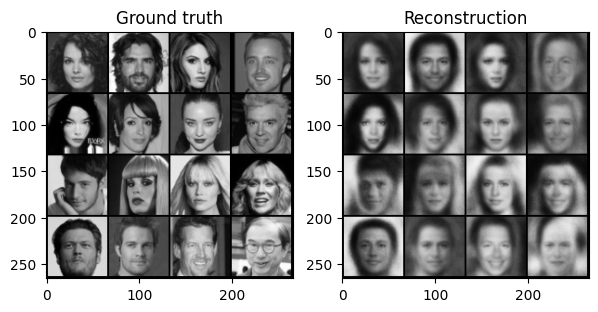

Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 2 of 5 took 228.817s
  training loss (in-iteration): 	0.007973
  validation loss: 			0.007258


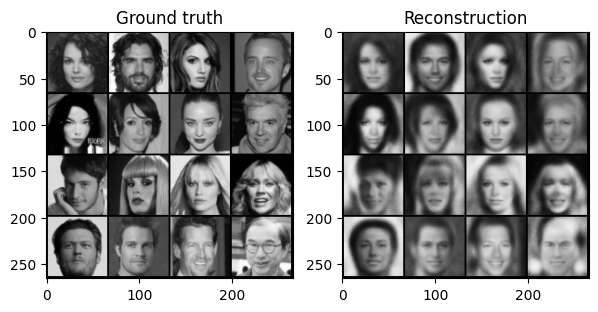

Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 3 of 5 took 233.924s
  training loss (in-iteration): 	0.006728
  validation loss: 			0.006812


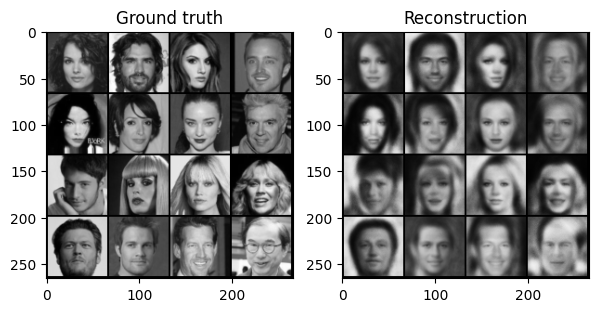

Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 4 of 5 took 247.572s
  training loss (in-iteration): 	0.006143
  validation loss: 			0.006028


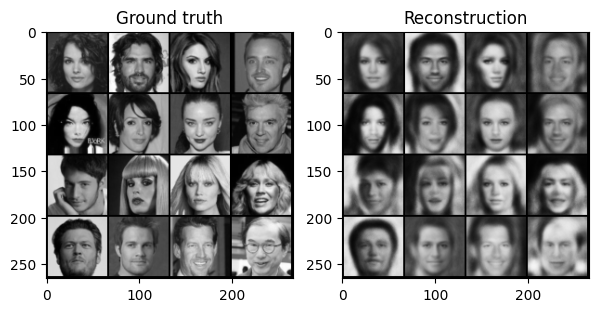

Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 5 of 5 took 240.828s
  training loss (in-iteration): 	0.005804
  validation loss: 			0.005625


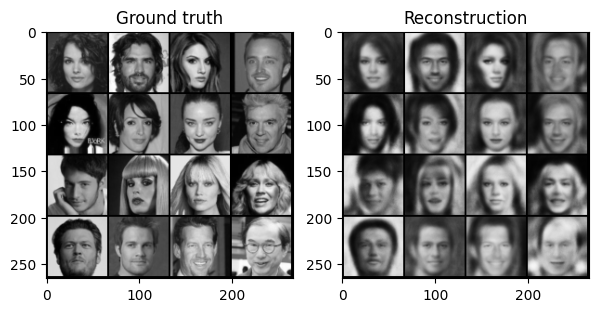

In [ ]:
_ = train_loop(autoencoder, optimizer, train_loader, val_loader, criterion, 5)

In [ ]:
torch.save(autoencoder, "ae.pt")

In [15]:
autoencoder = torch.load("ae.pt")

<ipython-input-15-4ede28537cf4>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder = torch.load("ae.pt")


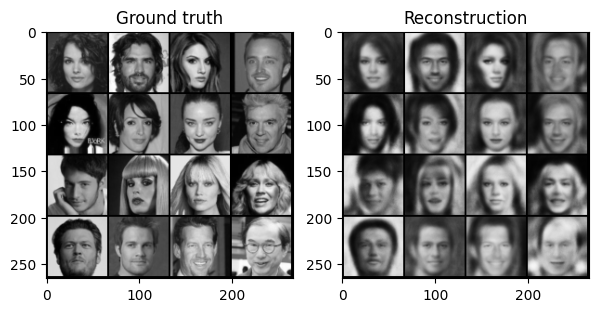

In [16]:
plot_reconstruction(autoencoder, val_loader)

Reconstruction is not bad, right?

# Sampling

Let's now sample several latent vectors and perform inference from $z$, reconstruct an image given some random $z$ representations.

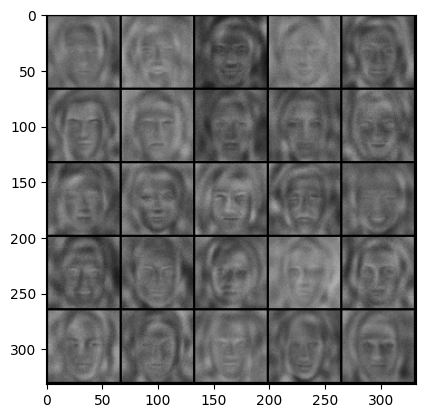

In [17]:
#!L
z = torch.randn(25, dimZ) * 0.5
reconstruction = autoencoder.decoder(z.to(device)).clamp(0, 1).reshape(25, 1, 64, 64)

plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))

So, if we sample $z$ from normal, whould we eventually generate all possible faces? What do you think?

# Variational Autoencoder

Bayesian approach in deep learning considers everything in terms of distributions. Now our encoder generates not just a vector $z$ but posterior ditribution $q(z|x)$. In our case distribution $q$ is Gaussian distibution $N(\mu, \sigma)$ with parameters $\mu$, $\sigma$. Technically, the first difference is that you need to split bottleneck layer in two. One dense layer will generate vector $\mu$, and another will generate vector $\sigma$. Reparametrization trick should be implemented using the **gaussian_sampler** layer, that generates random vetor $\epsilon$ and returns $\mu+\sigma\epsilon \sim N(\mu, \sigma)$ .

Since our decoder is also a function that generates distribution, we need to do the same splitting for output layer. When testing the model we will look only on mean values, so one of the output will be actual autoencoder output.

In this homework we only ask for implementation of the simplest version of VAE - one $z$ sample per input. You can consider to sample several outputs from one input and average them.

In [56]:
#!L
# to compare with conventional AE, keep these hyperparameters
# or change them for the values that you used before
dimZ = 250

# define the network
# you can start from https://github.com/pytorch/examples/blob/master/vae/main.py
# or Theano-based examples here https://github.com/Lasagne/Recipes/blob/master/examples/variational_autoencoder/variational_autoencoder.py
# and here https://github.com/y0ast/Variational-Autoencoder/blob/master/VAE.py
# but remember that this is not your ground truth since the data is not MNIST


class VAE(nn.Module):

    def __init__(self):
        super(VAE, self).__init__()

        self.encoder_mu = nn.Sequential(
            nn.Linear(64 * 64, dimZ),
            nn.ReLU(),
            nn.Linear(dimZ, dimZ),
        )
        self.encoder_logsigma = nn.Sequential(
            nn.Linear(64 * 64, dimZ),
            nn.ReLU(),
            nn.Linear(dimZ, dimZ),
        )
        self.decoder_mu = nn.Sequential(
            nn.Linear(dimZ, dimZ),
            nn.ReLU(),
            nn.Linear(dimZ, 64 * 64),
            nn.Sigmoid(),
        )
        self.decoder_logsigma = nn.Sequential(
            nn.Linear(dimZ, dimZ),
            nn.ReLU(),
            nn.Linear(dimZ, 64 * 64),
        )

    def gaussian_sampler(self, mu, logsigma):
        noise = torch.randn_like(mu)
        return noise * logsigma.exp() + mu

    def forward(self, img):
        img_shape = img.shape
        batch_size = img_shape[0]
        img = img.reshape(batch_size, -1)

        latent_mu = self.encoder_mu(img)
        latent_logsigma = self.encoder_logsigma(img)
        latent_sample = self.gaussian_sampler(latent_mu, latent_logsigma)

        reconstruction_mu = self.decoder_mu(latent_sample).reshape(img_shape)
        reconstruction_logsigma = self.decoder_logsigma(latent_sample).reshape(img_shape)

        return reconstruction_mu, reconstruction_logsigma, latent_mu, latent_logsigma

And the last, but not least! Place in the code where the most of the formulaes goes to - optimization objective. The objective for VAE has it's own name - variational lowerbound. And as for any lowerbound our intention is to maximize it. Here it is (for one sample $z$ per input $x$):

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z) \to max$$

Your next task is to implement two functions that compute KL-divergence and the second term - log-likelihood of an output. Here is some necessary math for your convenience:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$
$$\log p_{\theta}(x|z) = \sum_{i=1}^{dimX}\log p_{\theta}(x_i|z)=\sum_{i=1}^{dimX} \log \Big( \frac{1}{\sigma_i\sqrt{2\pi}}e^{-\frac{(\mu_i-x)^2}{2\sigma_i^2}} \Big)=...$$

Don't forget in the code that you are using $\log\sigma$ as variable. Explain, why not $\sigma$?

In [57]:
#!L
def KL_divergence(mu, logsigma):
    return - torch.sum(1 + 2 * logsigma - mu.pow(2) - logsigma.exp().pow(2), dim=-1) / 2

def log_likelihood(x, mu, logsigma):
    return torch.sum(- logsigma - 0.5 * np.log(2 * np.pi) - (mu - x).pow(2) / (2 * logsigma.exp().pow(2) + 1e-6), dim=-1)


def loss_vae(x, mu_gen, logsigma_gen, mu_z, logsigma_z):
    batch_size, *_ = x.shape

    x = x.view(batch_size, -1)

    mu_z = mu_z.view(batch_size, -1)
    logsigma_z = logsigma_z.view(batch_size, -1)

    mu_gen = mu_gen.view(batch_size, -1)
    logsigma_gen = logsigma_gen.view(batch_size, -1)

    return torch.mean(KL_divergence(mu_z, logsigma_z) - log_likelihood(x, mu_gen, logsigma_gen))

And train the model:

In [58]:
def plot_reconstruction_vae(model, dataloader):
    images, _ = list(islice(dataloader, 1))[0]
    mu_gen, _, _, _ = vae(images.to(device))
    reconstruction = mu_gen[:16].cpu().clamp(0, 1)
    images = images[:16].cpu()
    fig, ax = plt.subplots(ncols=2, figsize=(7, 4))
    ax[0].imshow(make_grid(images, nrow=4).permute(1, 2, 0))
    ax[0].set_title("Ground truth")
    ax[1].imshow(make_grid(reconstruction, nrow=4).permute(1, 2, 0))
    ax[1].set_title("Reconstruction")
    plt.show()

In [59]:
def eval_model(model, dataloader, loss_function):
    losses = []
    model.train(False)
    with torch.no_grad():
        for img, _ in tqdm(dataloader):
            img = img.to(device)
            output = model(img)
            loss = loss_function(img, *output)
            losses.append(loss.item())
    return np.mean(losses)


def train_model(model, optimizer, dataloader, loss_function):
    train_losses = []
    model.train(True)
    for img, _ in tqdm(dataloader):
        optimizer.zero_grad()

        img = img.to(device)
        output = model(img)

        loss = loss_function(img, *output)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    return np.mean(train_losses)


def train_loop(model, optimizer, train_dataloader, val_dataloader, loss_function, num_epochs=50):
    train_metrics = defaultdict(list)
    val_metrics = defaultdict(list)

    for epoch in range(num_epochs):
        start_time = time.time()
        print("Training")
        train_loss = train_model(model, optimizer, train_dataloader, loss_function)
        print("Validation")
        val_loss = eval_model(model, val_dataloader, loss_function)

        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss: \t\t\t{:.6f}".format(val_loss))
        if epoch % 5 == 0:
            plot_reconstruction_vae(model, val_loader)
        train_metrics['loss'].append(train_loss)
        val_metrics['loss'].append(val_loss)
    return train_metrics, val_metrics

In [60]:
vae = VAE().to(device)

criterion = loss_vae
optimizer = optim.Adam(vae.parameters())

Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 1 of 15 took 230.605s
  training loss (in-iteration): 	-2295.300062
  validation loss: 			-3159.930224


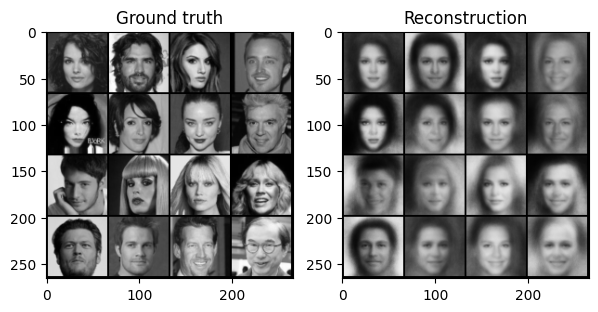

Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 2 of 15 took 233.918s
  training loss (in-iteration): 	-3559.308402
  validation loss: 			-3801.593051
Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 3 of 15 took 235.070s
  training loss (in-iteration): 	-3979.517497
  validation loss: 			-4062.271898
Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 4 of 15 took 234.426s
  training loss (in-iteration): 	-4122.727925
  validation loss: 			-4131.468606
Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 5 of 15 took 237.215s
  training loss (in-iteration): 	-4197.028030
  validation loss: 			-4146.510569
Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 6 of 15 took 234.663s
  training loss (in-iteration): 	-4235.369004
  validation loss: 			-4260.858440


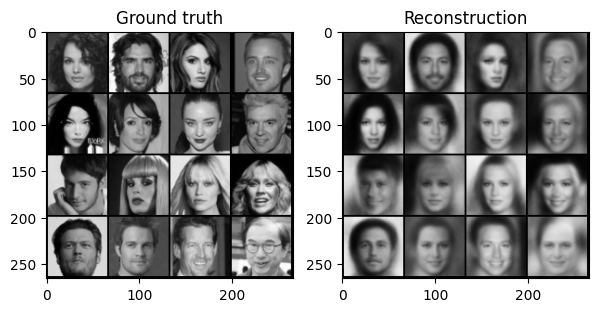

Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 7 of 15 took 236.064s
  training loss (in-iteration): 	-4265.660144
  validation loss: 			-4258.703664
Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 8 of 15 took 237.755s
  training loss (in-iteration): 	-4286.985397
  validation loss: 			-4246.769305
Training


  0%|          | 0/2544 [00:00<?, ?it/s]

Validation


  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 9 of 15 took 237.103s
  training loss (in-iteration): 	-4296.270560
  validation loss: 			-4310.962268
Training


  0%|          | 0/2544 [00:00<?, ?it/s]

In [ ]:
_ = train_loop(vae, optimizer, train_loader, val_loader, criterion, 15)

In [ ]:
torch.save(vae, "vae.pt")

In [ ]:
plot_reconstruction_vae(vae, val_loader)

And finally sample from VAE.

In [ ]:
num_images = 25
img_shape = (num_images, 1, 64, 64)

z = torch.normal(0, 1, size=(num_images, dimZ))
mu = vae.decoder_mu(z.to(device)).reshape(img_shape)
logsigma = vae.decoder_logsigma(z.to(device)).reshape(img_shape)

reconstruction = torch.normal(mu, logsigma.exp()).clamp(0, 1)

plt.imshow(make_grid(reconstruction.cpu(), nrow=5).permute(1, 2, 0))
plt.show()

Even if in practice you do not see the much difference between AE and VAE, or VAE is even worse, the little bayesian inside you should be jumping for joy right now.

In VAE you can truly sample from image distribution $p(x)$, while in AE there is no easy and correct way to do it.

# Congrats! and Bonus

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are face attributes in dataset. We're interesting in "Smiling" column (index 31 of the attribute vector), but feel free to try others as well! Here is the first task:

1) Extract the "Smilling" attribute and create a two sets of images: 10 smiling faces and 10 non-smiling ones.

2) Compute latent representations for each image in "smiling" set and average those latent vectors. Do the same for "non-smiling" set. You have found **"vector representation"** of the "smile" and "no smile" attribute.

3) Compute the difference: "smile" vector minus "non-smile" vector.

3) Now check if **"feature arithmetics"** works. Sample a face without smile, encode it and add the diff from p. 3. Check if it works with both AE and VAE.

<img src="https://github.com/yandexdataschool/deep_vision_and_graphics/blob/fall24/homework03/linear.png?raw=1" alt="linear">